# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

> This is a classifcation problem, where the goal is to make a decision with binary output (need or don't need). Classification is for solving problems with discrete value outputs.

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1]:
# Import libraries
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

/Users/jjl/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [45]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = len(student_data)
n_features = len(student_data.columns)
n_passed = len(student_data[student_data.passed == 'yes'])
n_failed = len(student_data[student_data.passed == 'no'])
grad_rate = (float(n_passed)/n_students)*100
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 31
Graduation rate of the class: 67.09%


---

### Dataset Attributes

- school - student's school (binary: "GP" or "MS")
- sex - student's sex (binary: "F" - female or "M" - male)
- age - student's age (numeric: from 15 to 22)
- address - student's home address type (binary: "U" - urban or "R" - rural)
- famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
- Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)
- Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
- Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
- Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
- Fjob - father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
- reason - reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")
- guardian - student's guardian (nominal: "mother", "father" or "other")
- traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
- studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
- failures - number of past class failures (numeric: n if 1<=n<3, else 4)
- schoolsup - extra educational support (binary: yes or no)
- famsup - family educational support (binary: yes or no)
- paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
- activities - extra-curricular activities (binary: yes or no)
- nursery - attended nursery school (binary: yes or no)
- higher - wants to take higher education (binary: yes or no)
- internet - Internet access at home (binary: yes or no)
- romantic - with a romantic relationship (binary: yes or no)
- famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
- freetime - free time after school (numeric: from 1 - very low to 5 - very high)
- goout - going out with friends (numeric: from 1 - very low to 5 - very high)
- Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
- Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
- health - current health status (numeric: from 1 - very bad to 5 - very good)
- absences - number of school absences (numeric: from 0 to 93)
- passed - did the student pass the final exam (binary: yes or no)

In [8]:
## show unique str values, numerical range

def show_values(x):
    print "dataset shape: {} x {}\n".format(x.shape[0], x.shape[1])
    for col in list(x.columns):
        if type(x[col][0]) == str:
            print "{}: {}".format(col, x[col].unique())
        else:
            print "{}: {} - {}".format(col, x[col].min(), x[col].max())

In [ ]:
show_values(student_data)

In [18]:
student_data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000


In [4]:
student_data[:4]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes


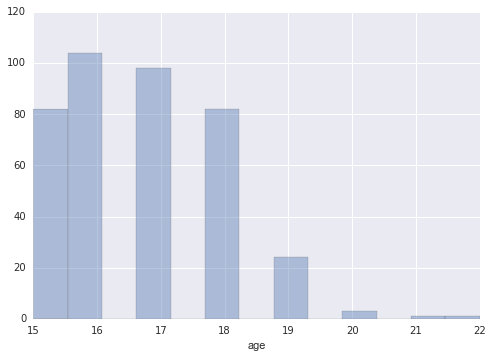

In [13]:
sns.distplot(student_data['age'], kde=False)

---
## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [3]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head(3)  # print the first few rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob     Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home  teacher   
1     GP   F   17       U     GT3       T     1     1  at_home    other   
2     GP   F   15       U     LE3       T     1     1  at_home    other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       yes      yes        no       5         3     3    1    1      3   
2   ...       yes      yes        no       4         3     2    2    3      3   

  a

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [4]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
            # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


In [9]:
show_values(X_all)

dataset shape: 395 x 48

school_GP: 0.0 - 1.0
school_MS: 0.0 - 1.0
sex_F: 0.0 - 1.0
sex_M: 0.0 - 1.0
age: 15 - 22
address_R: 0.0 - 1.0
address_U: 0.0 - 1.0
famsize_GT3: 0.0 - 1.0
famsize_LE3: 0.0 - 1.0
Pstatus_A: 0.0 - 1.0
Pstatus_T: 0.0 - 1.0
Medu: 0 - 4
Fedu: 0 - 4
Mjob_at_home: 0.0 - 1.0
Mjob_health: 0.0 - 1.0
Mjob_other: 0.0 - 1.0
Mjob_services: 0.0 - 1.0
Mjob_teacher: 0.0 - 1.0
Fjob_at_home: 0.0 - 1.0
Fjob_health: 0.0 - 1.0
Fjob_other: 0.0 - 1.0
Fjob_services: 0.0 - 1.0
Fjob_teacher: 0.0 - 1.0
reason_course: 0.0 - 1.0
reason_home: 0.0 - 1.0
reason_other: 0.0 - 1.0
reason_reputation: 0.0 - 1.0
guardian_father: 0.0 - 1.0
guardian_mother: 0.0 - 1.0
guardian_other: 0.0 - 1.0
traveltime: 1 - 4
studytime: 1 - 4
failures: 0 - 3
schoolsup: 0 - 1
famsup: 0 - 1
paid: 0 - 1
activities: 0 - 1
nursery: 0 - 1
higher: 0 - 1
internet: 0 - 1
romantic: 0 - 1
famrel: 1 - 5
freetime: 1 - 5
goout: 1 - 5
Dalc: 1 - 5
Walc: 1 - 5
health: 1 - 5
absences: 0 - 75


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [5]:
from sklearn import cross_validation

# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, \
                                                                     test_size=int(num_test), random_state=0)
#X_train = ?
#y_train = ?
#X_test = ?
#y_test = ?
print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])

# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


---
## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What is the theoretical O(n) time & space complexity in terms of input size?
- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

### Model #1: Decision Tree

In [229]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)

# TODO: Choose a model, import it and instantiate an object
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
#print clf  # you can inspect the learned model by printing it

Training DecisionTreeClassifier...
Done!
Training time (secs): 0.015


In [269]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant
subsets = np.linspace(len(X_train)/10, len(X_train), 10, dtype=int)
for i,s in enumerate(subsets):
    train_predict(clf, X_train[:s], y_train[:s], X_test, y_test)

------------------------------------------
Training set size: 30
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.001
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for training set: 1.0
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.762711864407
------------------------------------------
Training set size: 60
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.000
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for training set: 1.0
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.693548387097
------------------------------------------
Training set size: 90
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.001
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for training set: 1.0

In [230]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')

train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)

Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.009
F1 score for training set: 1.0


In [233]:
# Predict on test data
print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.003
F1 score for test set: 0.735042735043


---
### Model #2: Random Forest

In [6]:
'''
Define various functions to utilize for each new model
'''

# show model training time
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)


# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))


# Run the helper function above for desired subsets of training data
# Note: Keep the test set constant
def train_predict_size(clf, size):
    subsets = np.linspace(len(X_train)/size, len(X_train), size, dtype=int)
    for i,s in enumerate(subsets):
        train_predict(clf, X_train[:s], y_train[:s], X_test, y_test)


# Predict on training set and compute F1 score`
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


# Predict on training set and compute F1 score
def show_f1_score(clf, X_set, y_set, dataset):
    score = predict_labels(clf, X_set, y_set)
    print "F1 score for {} set: {}".format(dataset, score)

In [31]:
# TODO: Choose a model, import it and instantiate an object
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=5)

# Fit model to training data
train_classifier(rf, X_train, y_train)  # note: using entire training set here
#print clf  # you can inspect the learned model by printing it

Training RandomForestClassifier...
Done!
Training time (secs): 0.030


In [32]:
# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant
train_predict_size(rf, 5)


------------------------------------------
Training set size: 60
Training RandomForestClassifier...
Done!
Training time (secs): 0.035
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.974358974359
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.748201438849
------------------------------------------
Training set size: 120
Training RandomForestClassifier...
Done!
Training time (secs): 0.020
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.935064935065
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.725925925926
------------------------------------------
Training set size: 180
Training RandomForestClassifier...
Done!
Training time (secs): 0.037
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.001
F1 sco

In [33]:
# Predict on training set and compute F1 score
show_f1_score(rf, X_train, y_train, 'training')


Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.002
F1 score for training set: 0.883002207506


In [34]:
# Predict on test data
show_f1_score(rf, X_test, y_test, 'test')


Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.789115646259


---
### Model #3: SVM (Support Vector Machine)

In [8]:
# TODO: Choose a model, import it and instantiate an object
from sklearn import svm
clf_svm = svm.SVC()

# Fit model to training data
train_classifier(clf_svm, X_train, y_train)  # note: using entire training set here
#print clf  # you can inspect the learned model by printing it

Training SVC...
Done!
Training time (secs): 0.017


In [9]:
# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant
train_predict_size(clf_svm, 5)


------------------------------------------
Training set size: 60
Training SVC...
Done!
Training time (secs): 0.001
Predicting labels using SVC...
Done!
Prediction time (secs): 0.008
F1 score for training set: 0.89156626506
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.779411764706
------------------------------------------
Training set size: 120
Training SVC...
Done!
Training time (secs): 0.002
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.869047619048
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.777777777778
------------------------------------------
Training set size: 180
Training SVC...
Done!
Training time (secs): 0.003
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for training set: 0.881481481481
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.767123287671
------------

In [10]:
# Predict on training set and compute F1 score
show_f1_score(clf_svm, X_train, y_train, 'training')


Predicting labels using SVC...
Done!
Prediction time (secs): 0.006
F1 score for training set: 0.869198312236


In [11]:
# Predict on test data
show_f1_score(clf_svm, X_test, y_test, 'test')


Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.758620689655


---
## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

In [ ]:
# TODO: Fine-tune your model and report the best F1 score